## Database Implementation and Data Querying

In [49]:
import sqlite3
import pandas as pd

db_path = "./Database/flight_data.db"
flights_csv  = "./Dataset/flights.csv"
airports_csv = "./Dataset/airports.csv"
airlines_csv = "./Dataset/airlines.csv"

In [50]:
airports_df  = pd.read_csv(airports_csv)
airlines_df  = pd.read_csv(airlines_csv)

airports_df = airports_df[["IATA_CODE", "AIRPORT", "CITY", "A_STATE",
                           "COUNTRY", "LATITUDE", "LONGITUDE"]].drop_duplicates()
airlines_df = airlines_df[["IATA_CODE", "AIRLINE"]].drop_duplicates()


In [51]:
flights_df = pd.read_csv(flights_csv)

flights_df = flights_df[["A_YEAR", "A_MONTH","A_DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER",
                         "TAIL_NUMBER", "ORIGIN_AIRPORT",
                         "DESTINATION_AIRPORT","SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT",
                            "WHEELS_OFF", "SCHEDULED_TIME", "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "WHEELS_ON", "TAXI_IN",
                         "SCHEDULED_ARRIVAL", "ARRIVAL_TIME", "ARRIVAL_DELAY", "DIVERTED", "CANCELLED",
                         "CANCELLATION_REASON", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY",
                         "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].drop_duplicates()
flights_df.insert(0, "flight_id",  range(1, len(flights_df)+1))

In [52]:
con = sqlite3.connect(db_path)
con.execute("PRAGMA foreign_keys = ON;")
cur = con.cursor()

for tbl in ("flights", "airports", "airlines"):
    cur.executescript(f"DROP TABLE IF EXISTS {tbl};")

cur.executescript("""
CREATE TABLE airports(
    IATA_CODE TEXT PRIMARY KEY,
    AIRPORT TEXT,
    CITY TEXT,
    A_STATE TEXT,
    COUNTRY TEXT,
    LATITUDE REAL,
    LONGITUDE REAL
);
""")

cur.executescript("""
CREATE TABLE airlines(
    IATA_CODE    TEXT PRIMARY KEY,
    AIRLINE      TEXT
);
""")

cur.executescript("""
CREATE TABLE flights(
    flight_id INT PRIMARY KEY,
    A_YEAR INT,
    A_MONTH INT,
    A_DAY INT,
    DAY_OF_WEEK INT,
    AIRLINE TEXT,
    FLIGHT_NUMBER INT,
    TAIL_NUMBER TEXT,
    ORIGIN_AIRPORT TEXT,
    DESTINATION_AIRPORT TEXT,
    SCHEDULED_DEPARTURE INT,
    DEPARTURE_TIME INT,
    DEPARTURE_DELAY INT,
    TAXI_OUT INT,
    WHEELS_OFF INT,
    SCHEDULED_TIME INT,
    ELAPSED_TIME INT,
    AIR_TIME INT,
    DISTANCE INT,
    WHEELS_ON INT,
    TAXI_IN INT,
    SCHEDULED_ARRIVAL INT,
    ARRIVAL_TIME INT,
    ARRIVAL_DELAY INT,
    DIVERTED INT,
    CANCELLED INT,
    CANCELLATION_REASON TEXT,
    AIR_SYSTEM_DELAY INT,
    SECURITY_DELAY INT,
    AIRLINE_DELAY INT,
    LATE_AIRCRAFT_DELAY INT,
    WEATHER_DELAY INT,

    FOREIGN KEY (ORIGIN_AIRPORT) REFERENCES airports(IATA_CODE),
    FOREIGN KEY (DESTINATION_AIRPORT) REFERENCES airports(IATA_CODE),
    FOREIGN KEY (AIRLINE) REFERENCES airlines(IATA_CODE)
);
""")
con.commit()


In [53]:
airports_df.to_sql("airports", con, if_exists="append", index=False)
airlines_df.to_sql("airlines", con, if_exists="append", index=False)
flights_df.to_sql("flights",  con, if_exists="append", index=False)

con.commit()
con.close()
print("SQLite database built at", db_path)


SQLite database built at ./Database/flight_data.db


In [54]:
import sqlite3, pandas as pd
from tabulate import tabulate
def run_sql(
    sql: str,
    params: tuple | None = None,
    head_rows: int = 6,
    tail_rows: int = 3,
    tablefmt: str = "psql",
    return_df: bool = False,
):
    with sqlite3.connect(db_path) as con:
        con.execute("PRAGMA foreign_keys = ON;")
        df = pd.read_sql_query(sql, con, params=params)

    n = len(df)
    if n == 0:
        print("(0 rows)")
        return pd.DataFrame() if return_df else None

    if n <= 20:
        short = df
    else:
        ellipsis_row = pd.DataFrame(
            {c: "…" for c in df.columns}, index=["…"]
        )
        short = pd.concat([df.head(head_rows), ellipsis_row, df.tail(tail_rows)])
    in_nb = False
    try:
        from IPython import get_ipython
        in_nb = "IPKernelApp" in get_ipython().config
    except Exception:
        pass

    if in_nb:
        from IPython.display import display, HTML
        display(short)
        display(HTML(f"<em>{n:,} rows total</em>"))
    else:
        print(tabulate(short, headers="keys", tablefmt=tablefmt, showindex=False))
        print(f"\n[{n:,} rows total]")

    return df if return_df else None


In [55]:
run_sql("""
SELECT *
FROM airports
""")


,IATA_CODE,AIRPORT,CITY,A_STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
…,…,…,…,…,…,…,…
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023
321,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597


In [56]:
run_sql("""
SELECT *
FROM airlines
""")


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [57]:
run_sql("""
SELECT *
FROM flights
""")

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,408.0,-22.0,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,741.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN
2,3,2015,1,1,4,US,840,N171US,SFO,CLT,...,811.0,5.0,0,0,None,NaN,NaN,NaN,NaN,NaN
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,756.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN
4,5,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,259.0,-21.0,0,0,None,NaN,NaN,NaN,NaN,NaN
5,6,2015,1,1,4,DL,806,N3730B,SFO,MSP,...,610.0,8.0,0,0,None,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,...,…,…,…,…,…,…,…,…,…,…
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,927.0,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN
499999,500000,2015,2,3,2,WN,136,N352SW,MSP,MKE,...,702.0,-23.0,0,0,None,NaN,NaN,NaN,NaN,NaN


In [58]:
run_sql("""
SELECT F.AIRLINE, COUNT(*) AS NumOfFlights
FROM flights F
GROUP BY F.AIRLINE;
""")


,AIRLINE,NumOfFlights
0,AA,46950
1,AS,14149
2,B6,23062
3,DL,68555
4,EV,52965
5,F9,7291
6,HA,6858
7,MQ,31896
8,NK,9324
9,OO,51184


In [59]:
run_sql("""
SELECT F.AIRLINE, AVG(F.DEPARTURE_DELAY) AS Delay
FROM flights F
GROUP BY F.AIRLINE;
""")


,AIRLINE,Delay
0,AA,10.643729
1,AS,3.430815
2,B6,10.774558
3,DL,6.775430
4,EV,10.043026
5,F9,19.664576
6,HA,1.109583
7,MQ,16.141276
8,NK,14.016792
9,OO,12.458124


In [60]:
run_sql("""
SELECT F.AIRLINE, SUM(F.CANCELLED) AS Cancelled
FROM flights F
GROUP BY F.AIRLINE;
""")

,AIRLINE,Cancelled
0,AA,1324
1,AS,83
2,B6,1479
3,DL,938
4,EV,2523
5,F9,122
6,HA,27
7,MQ,3136
8,NK,158
9,OO,1623


In [61]:
run_sql("""
SELECT F.ORIGIN_AIRPORT, F.DESTINATION_AIRPORT, AVG(F.AIR_TIME) AS AVG_FLY_TIME
FROM flights F
GROUP BY F.ORIGIN_AIRPORT, F.DESTINATION_AIRPORT;
""")

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,AVG_FLY_TIME
0,ABE,ATL,111.540541
1,ABE,DTW,83.267606
2,ABE,ORD,112.263158
3,ABI,DFW,32.394191
4,ABQ,ATL,150.263158
5,ABQ,BWI,192.121212
…,…,…,…
4177,YAK,CDV,36.84375
4178,YAK,JNU,35.133333
4179,YUM,PHX,32.188571


In [62]:
run_sql("""
SELECT f1.flight_id AS FLIGHT_ID, f1.ORIGIN_AIRPORT, a1.A_STATE AS ORIGIN_AIRPORT_STATE, a1.AIRPORT AS ORIGIN_AIRPORT_FULL_NAME,
 f1.DESTINATION_AIRPORT, a2.A_STATE as DESTINATION_AIRPORT_STATE, a2.AIRPORT AS DESTINATION_AIRPORT_FULL_NAME
FROM flights f1, airports a1, airports a2
WHERE f1.ORIGIN_AIRPORT = a1.IATA_CODE AND f1.DESTINATION_AIRPORT = a2.IATA_CODE;
""")

,FLIGHT_ID,ORIGIN_AIRPORT,ORIGIN_AIRPORT_STATE,ORIGIN_AIRPORT_FULL_NAME,DESTINATION_AIRPORT,DESTINATION_AIRPORT_STATE,DESTINATION_AIRPORT_FULL_NAME
0,1,ANC,AK,Ted Stevens Anchorage International Airport,SEA,WA,Seattle-Tacoma International Airport
1,2,LAX,CA,Los Angeles International Airport,PBI,FL,Palm Beach International Airport
2,3,SFO,CA,San Francisco International Airport,CLT,NC,Charlotte Douglas International Airport
3,4,LAX,CA,Los Angeles International Airport,MIA,FL,Miami International Airport
4,5,SEA,WA,Seattle-Tacoma International Airport,ANC,AK,Ted Stevens Anchorage International Airport
5,6,SFO,CA,San Francisco International Airport,MSP,MN,Minneapolis-Saint Paul International Airport
…,…,…,…,…,…,…,…
499997,499998,MDW,IL,Chicago Midway International Airport,PIT,PA,Pittsburgh International Airport
499998,499999,MDW,IL,Chicago Midway International Airport,TPA,FL,Tampa International Airport
499999,500000,MSP,MN,Minneapolis-Saint Paul International Airport,MKE,WI,General Mitchell International Airport


In [63]:
run_sql("""
SELECT f.flight_id AS FLIGHT_ID, f.AIRLINE AS IATA_CODE, a.AIRLINE AS AIRLINE_NAME
FROM flights f, airlines a
WHERE f.AIRLINE = a.IATA_CODE;
""")

,FLIGHT_ID,IATA_CODE,AIRLINE_NAME
0,1,AS,Alaska Airlines Inc.
1,2,AA,American Airlines Inc.
2,3,US,US Airways Inc.
3,4,AA,American Airlines Inc.
4,5,AS,Alaska Airlines Inc.
5,6,DL,Delta Air Lines Inc.
…,…,…,…
499997,499998,WN,Southwest Airlines Co.
499998,499999,WN,Southwest Airlines Co.
499999,500000,WN,Southwest Airlines Co.


## Feature Engineering, Data Preprocessing, and Preparation for Modeling

In [64]:
import sqlite3
import pandas as pd

con = sqlite3.connect(db_path)
flights = pd.read_sql_query("SELECT * FROM flights", con)
airports = pd.read_sql_query("SELECT * FROM airports", con)
airlines = pd.read_sql_query("SELECT * FROM airlines", con)
con.commit()
con.close()

In [65]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,408.0,-22.0,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,741.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN
2,3,2015,1,1,4,US,840,N171US,SFO,CLT,...,811.0,5.0,0,0,None,NaN,NaN,NaN,NaN,NaN
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,756.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN
4,5,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,259.0,-21.0,0,0,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,910.0,-20.0,0,0,None,NaN,NaN,NaN,NaN,NaN
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,744.0,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,927.0,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN


In [66]:
airports

,IATA_CODE,AIRPORT,CITY,A_STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [67]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [68]:
# Adding Latitude and longitude of origin and destination airport:
airp_cols = ["IATA_CODE", "LATITUDE", "LONGITUDE"]
orig = airports[airp_cols].rename(columns=lambda c: "ORIG_" + c if c!="IATA_CODE" else "ORIGIN_AIRPORT")
dest = airports[airp_cols].rename(columns=lambda c: "DEST_" + c if c!="IATA_CODE" else "DESTINATION_AIRPORT")

flights = (flights
           .merge(orig,  on="ORIGIN_AIRPORT",      how="left")
           .merge(dest,  on="DESTINATION_AIRPORT", how="left")
           .merge(airlines, on="AIRLINE",           how="left"))

flights = flights.drop(columns=['IATA_CODE'], errors='ignore')

In [69]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,1,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,None,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,None,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,26.68316,-80.09559
2,3,2015,1,1,4,US,840,N171US,SFO,CLT,...,None,NaN,NaN,NaN,NaN,NaN,37.61900,-122.37484,35.21401,-80.94313
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,None,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,25.79325,-80.29056
4,5,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,None,NaN,NaN,NaN,NaN,NaN,47.44898,-122.30931,61.17432,-149.99619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,None,NaN,NaN,NaN,NaN,NaN,32.84711,-96.85177,28.42889,-81.31603
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,None,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,39.85841,-104.66700
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,A,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,40.49147,-80.23287
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,None,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,27.97547,-82.53325


In [70]:
# Add date column:
flights['FLIGHT_DATE'] = pd.to_datetime(
    flights[['A_YEAR','A_MONTH','A_DAY']].rename(
        columns={'A_YEAR':'year','A_MONTH':'month','A_DAY':'day'}),
    format="%Y-%m-%d"
)

flights['DAY_OF_YEAR'] = flights['FLIGHT_DATE'].dt.dayofyear
flights['WEEK_OF_YEAR'] = flights['FLIGHT_DATE'].dt.isocalendar().week
flights['QUARTER'] = flights['FLIGHT_DATE'].dt.quarter
flights['IS_WEEKEND'] = flights['FLIGHT_DATE'].dt.weekday >= 5

flights['DEP_HOUR'] = (flights['SCHEDULED_DEPARTURE'] // 100).astype(int)
bins = [0, 6, 12, 18, 24]
labels = ['early_morning','morning','afternoon','evening']
flights['DEP_TIME_BUCKET'] = pd.cut(flights['DEP_HOUR'], bins=bins, labels=labels, right=False)

In [71]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,FLIGHT_DATE,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,IS_WEEKEND,DEP_HOUR,DEP_TIME_BUCKET
0,1,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,-149.99619,47.44898,-122.30931,2015-01-01,1,1,1,False,0,early_morning
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,-118.40807,26.68316,-80.09559,2015-01-01,1,1,1,False,0,early_morning
2,3,2015,1,1,4,US,840,N171US,SFO,CLT,...,-122.37484,35.21401,-80.94313,2015-01-01,1,1,1,False,0,early_morning
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,-118.40807,25.79325,-80.29056,2015-01-01,1,1,1,False,0,early_morning
4,5,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,-122.30931,61.17432,-149.99619,2015-01-01,1,1,1,False,0,early_morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,-96.85177,28.42889,-81.31603,2015-02-03,34,6,1,False,6,morning
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,-87.75242,39.85841,-104.66700,2015-02-03,34,6,1,False,6,morning
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,-87.75242,40.49147,-80.23287,2015-02-03,34,6,1,False,6,morning
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,-87.75242,27.97547,-82.53325,2015-02-03,34,6,1,False,6,morning


In [72]:
import pyproj
import numpy as np

# Add distance column:
proj = pyproj.Proj(proj='latlong', datum='WGS84')
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(a))

flights['DISTANCE_KM'] = haversine(
    flights['ORIG_LATITUDE'], flights['ORIG_LONGITUDE'],
    flights['DEST_LATITUDE'], flights['DEST_LONGITUDE']
)

In [73]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DEST_LATITUDE,DEST_LONGITUDE,FLIGHT_DATE,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,IS_WEEKEND,DEP_HOUR,DEP_TIME_BUCKET,DISTANCE_KM
0,1,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,47.44898,-122.30931,2015-01-01,1,1,1,False,0,early_morning,2325.632164
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,26.68316,-80.09559,2015-01-01,1,1,1,False,0,early_morning,3742.721144
2,3,2015,1,1,4,US,840,N171US,SFO,CLT,...,35.21401,-80.94313,2015-01-01,1,1,1,False,0,early_morning,3686.954140
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,25.79325,-80.29056,2015-01-01,1,1,1,False,0,early_morning,3762.636680
4,5,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,61.17432,-149.99619,2015-01-01,1,1,1,False,0,early_morning,2325.632164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,28.42889,-81.31603,2015-02-03,34,6,1,False,6,morning,1563.584642
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,39.85841,-104.66700,2015-02-03,34,6,1,False,6,morning,1436.930721
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,40.49147,-80.23287,2015-02-03,34,6,1,False,6,morning,645.718100
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,27.97547,-82.53325,2015-02-03,34,6,1,False,6,morning,1606.905349


In [74]:
flights = flights.sort_values(["AIRLINE","FLIGHT_DATE"])
flights["ARR_DELAY_FILLED"] = flights["ARRIVAL_DELAY"].fillna(0)

flights["AIRLINE_7D_MEAN"] = (
    flights
    .groupby("AIRLINE")["ARR_DELAY_FILLED"]
    .rolling(window=7, min_periods=1)
    .mean()
    .reset_index(level=0,drop=True)
)

flights.drop(columns="ARR_DELAY_FILLED", inplace=True)

In [75]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DEST_LONGITUDE,FLIGHT_DATE,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,IS_WEEKEND,DEP_HOUR,DEP_TIME_BUCKET,DISTANCE_KM,AIRLINE_7D_MEAN
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,-80.09559,2015-01-01,1,1,1,False,0,early_morning,3742.721144,-9.000000
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,-80.29056,2015-01-01,1,1,1,False,0,early_morning,3762.636680,-9.000000
8,9,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,...,-97.03720,2015-01-01,1,1,1,False,0,early_morning,2352.029788,-10.333333
11,12,2015,1,1,4,AA,1674,N853AA,LAS,MIA,...,-80.29056,2015-01-01,1,1,1,False,0,early_morning,3494.189002,-10.250000
21,22,2015,1,1,4,AA,371,N3GXAA,SEA,MIA,...,-80.29056,2015-01-01,1,1,1,False,1,early_morning,4379.482722,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,-81.31603,2015-02-03,34,6,1,False,6,morning,1563.584642,8.428571
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,-104.66700,2015-02-03,34,6,1,False,6,morning,1436.930721,7.428571
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,-80.23287,2015-02-03,34,6,1,False,6,morning,645.718100,9.000000
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,-82.53325,2015-02-03,34,6,1,False,6,morning,1606.905349,5.857143


In [76]:
flights['DELAY_PER_KM'] = flights['ARRIVAL_DELAY'] / flights['DISTANCE_KM']

with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(flights)

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,FLIGHT_DATE,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,IS_WEEKEND,DEP_HOUR,DEP_TIME_BUCKET,DISTANCE_KM,AIRLINE_7D_MEAN,DELAY_PER_KM
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,26.68316,-80.09559,2015-01-01,1,1,1,False,0,early_morning,3742.721144,-9.000000,-0.002405
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,None,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,25.79325,-80.29056,2015-01-01,1,1,1,False,0,early_morning,3762.636680,-9.000000,-0.002392
8,9,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,-11.0,17.0,36.0,195.0,193.0,173.0,1464,529.0,3.0,545,532.0,-13.0,0,0,None,NaN,NaN,NaN,NaN,NaN,37.61900,-122.37484,32.89595,-97.03720,2015-01-01,1,1,1,False,0,early_morning,2352.029788,-10.333333,-0.005527
11,12,2015,1,1,4,AA,1674,N853AA,LAS,MIA,35,27.0,-8.0,21.0,48.0,268.0,266.0,238.0,2174,746.0,7.0,803,753.0,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,36.08036,-115.15233,25.79325,-80.29056,2015-01-01,1,1,1,False,0,early_morning,3494.189002,-10.250000,-0.002862
21,22,2015,1,1,4,AA,371,N3GXAA,SEA,MIA,100,52.0,-8.0,30.0,122.0,338.0,347.0,311.0,2724,933.0,6.0,938,939.0,1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,47.44898,-122.30931,25.79325,-80.29056,2015-01-01,1,1,1,False,1,early_morning,4379.482722,-8.000000,0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,605,558.0,-7.0,8.0,606.0,145.0,132.0,115.0,973,901.0,9.0,930,910.0,-20.0,0,0,None,NaN,NaN,NaN,NaN,NaN,32.84711,-96.85177,28.42889,-81.31603,2015-02-03,34,6,1,False,6,morning,1563.584642,8.428571,-0.012791
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,605,605.0,0.0,19.0,624.0,165.0,159.0,133.0,895,737.0,7.0,750,744.0,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,39.85841,-104.66700,2015-02-03,34,6,1,False,6,morning,1436.930721,7.428571,-0.004176
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,605,NaN,NaN,NaN,NaN,85.0,NaN,NaN,402,NaN,NaN,830,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,40.49147,-80.23287,2015-02-03,34,6,1,False,6,morning,645.718100,9.000000,NaN
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,605,605.0,0.0,11.0,616.0,160.0,142.0,126.0,997,922.0,5.0,945,927.0,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN,41.78598,-87.75242,27.97547,-82.53325,2015-02-03,34,6,1,False,6,morning,1606.905349,5.857143,-0.011202


In [77]:
delay_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
flights[delay_cols] = flights[delay_cols].fillna(0)

delay_basic_cols = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY']
flights[delay_basic_cols] = flights[delay_basic_cols].fillna(0)

time_cols = ['DEPARTURE_TIME', 'ARRIVAL_TIME', 'WHEELS_ON', 'WHEELS_OFF',
             'TAXI_OUT', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']

for col in time_cols:
    flights.loc[flights['CANCELLED'] == 1, col] = flights.loc[flights['CANCELLED'] == 1, col].fillna(-1)

for col in time_cols:
    flights[col] = flights[col].fillna(flights[col].median())

cat_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
flights[cat_cols] = flights[cat_cols].fillna('Unknown')

flights = flights.drop(columns=['CANCELLATION_REASON'], errors='ignore')


In [78]:
flights

,flight_id,A_YEAR,A_MONTH,A_DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,FLIGHT_DATE,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,IS_WEEKEND,DEP_HOUR,DEP_TIME_BUCKET,DISTANCE_KM,AIRLINE_7D_MEAN,DELAY_PER_KM
1,2,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,2015-01-01,1,1,1,False,0,early_morning,3742.721144,-9.000000,-0.002405
3,4,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,2015-01-01,1,1,1,False,0,early_morning,3762.636680,-9.000000,-0.002392
8,9,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,...,2015-01-01,1,1,1,False,0,early_morning,2352.029788,-10.333333,-0.005527
11,12,2015,1,1,4,AA,1674,N853AA,LAS,MIA,...,2015-01-01,1,1,1,False,0,early_morning,3494.189002,-10.250000,-0.002862
21,22,2015,1,1,4,AA,371,N3GXAA,SEA,MIA,...,2015-01-01,1,1,1,False,1,early_morning,4379.482722,-8.000000,0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,2015,2,3,2,WN,740,N647SW,DAL,MCO,...,2015-02-03,34,6,1,False,6,morning,1563.584642,8.428571,-0.012791
499996,499997,2015,2,3,2,WN,1711,N8315C,MDW,DEN,...,2015-02-03,34,6,1,False,6,morning,1436.930721,7.428571,-0.004176
499997,499998,2015,2,3,2,WN,371,N438WN,MDW,PIT,...,2015-02-03,34,6,1,False,6,morning,645.718100,9.000000,NaN
499998,499999,2015,2,3,2,WN,1267,N211WN,MDW,TPA,...,2015-02-03,34,6,1,False,6,morning,1606.905349,5.857143,-0.011202


In [79]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_feats = ['DISTANCE_KM', 'AIRLINE_7D_MEAN','DEP_HOUR','DELAY_PER_KM','DEPARTURE_DELAY',
                'ARRIVAL_DELAY', 'ELAPSED_TIME']

cat_feats = ['DAY_OF_WEEK', 'WEEK_OF_YEAR', 'IS_WEEKEND']
unchanged_columns = ['flight_id', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT','TAIL_NUMBER']

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
    # ('scale',  StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats),
    ('passthrough', 'passthrough', unchanged_columns)
])

X = preprocessor.fit_transform(flights)
y = (flights['ARRIVAL_DELAY'] > 15).astype(int)

In [80]:
drop_cols = ['flight_id','A_YEAR','A_MONTH','A_DAY','SCHEDULED_DEPARTURE',
             'ORIG_LATITUDE','ORIG_LONGITUDE','DEST_LATITUDE','DEST_LONGITUDE']
flights = flights.drop(columns=drop_cols, errors='ignore')

columns = preprocessor.get_feature_names_out()
processed = pd.DataFrame(X,
                         index=flights.index,
                         columns = (
                             columns
                         ))
processed['TARGET_LATE'] = y
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(processed)

,num__DISTANCE_KM,num__AIRLINE_7D_MEAN,num__DEP_HOUR,num__DELAY_PER_KM,num__DEPARTURE_DELAY,num__ARRIVAL_DELAY,num__ELAPSED_TIME,cat__DAY_OF_WEEK,cat__WEEK_OF_YEAR,cat__IS_WEEKEND,passthrough__flight_id,passthrough__AIRLINE,passthrough__ORIGIN_AIRPORT,passthrough__DESTINATION_AIRPORT,passthrough__TAIL_NUMBER,TARGET_LATE
1,3742.721144,-9.0,0.0,-0.002405,-8.0,-9.0,279.0,3.0,0.0,0.0,2,AA,LAX,PBI,N3KUAA,0
3,3762.63668,-9.0,0.0,-0.002392,-5.0,-9.0,281.0,3.0,0.0,0.0,4,AA,LAX,MIA,N3HYAA,0
8,2352.029788,-10.333333,0.0,-0.005527,-11.0,-13.0,193.0,3.0,0.0,0.0,9,AA,SFO,DFW,N3LAAA,0
11,3494.189002,-10.25,0.0,-0.002862,-8.0,-10.0,266.0,3.0,0.0,0.0,12,AA,LAS,MIA,N853AA,0
21,4379.482722,-8.0,1.0,0.000228,-8.0,1.0,347.0,3.0,0.0,0.0,22,AA,SEA,MIA,N3GXAA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1563.584642,8.428571,6.0,-0.012791,-7.0,-20.0,132.0,1.0,5.0,0.0,499996,WN,DAL,MCO,N647SW,0
499996,1436.930721,7.428571,6.0,-0.004176,0.0,-6.0,159.0,1.0,5.0,0.0,499997,WN,MDW,DEN,N8315C,0
499997,645.7181,9.0,6.0,-0.002963,0.0,0.0,-1.0,1.0,5.0,0.0,499998,WN,MDW,PIT,N438WN,0
499998,1606.905349,5.857143,6.0,-0.011202,0.0,-18.0,142.0,1.0,5.0,0.0,499999,WN,MDW,TPA,N211WN,0


In [81]:
drop_cols = ['TARGET_LATE', 'passthrough__flight_id']
processed = processed.drop(columns=drop_cols, errors='ignore')
processed = processed.dropna(subset=['passthrough__TAIL_NUMBER'])

In [82]:
from sklearn.preprocessing import LabelEncoder   # scikit-learn, optional

# --- option 1: with scikit-learn ------------------------------------------
le = LabelEncoder()
processed["passthrough__TAIL_NUMBER"] = le.fit_transform(processed["passthrough__TAIL_NUMBER"])
processed["passthrough__DESTINATION_AIRPORT"] = le.fit_transform(processed["passthrough__DESTINATION_AIRPORT"])
processed["passthrough__ORIGIN_AIRPORT"] = le.fit_transform(processed["passthrough__ORIGIN_AIRPORT"])
processed["passthrough__AIRLINE"] = le.fit_transform(processed["passthrough__AIRLINE"])

In [83]:
processed.reset_index(drop=True, inplace=True)
transform_cols = ["num__DISTANCE_KM", "num__AIRLINE_7D_MEAN", "num__DEP_HOUR",
                    "num__DELAY_PER_KM", "num__DEPARTURE_DELAY", "num__ELAPSED_TIME", "num__ARRIVAL_DELAY"]    # <- list *all* numeric feature names
for col in transform_cols:
    processed[col] = processed[col].astype("float32")

cat_cols = ["cat__DAY_OF_WEEK", "cat__WEEK_OF_YEAR", "cat__IS_WEEKEND", "passthrough__AIRLINE",
                 "passthrough__ORIGIN_AIRPORT", "passthrough__DESTINATION_AIRPORT", "passthrough__TAIL_NUMBER"]  # <- integer-coded categoricals

for col in cat_cols:
    processed[col] = processed[col].astype("int32")

In [84]:
processed

,num__DISTANCE_KM,num__AIRLINE_7D_MEAN,num__DEP_HOUR,num__DELAY_PER_KM,num__DEPARTURE_DELAY,num__ARRIVAL_DELAY,num__ELAPSED_TIME,cat__DAY_OF_WEEK,cat__WEEK_OF_YEAR,cat__IS_WEEKEND,passthrough__AIRLINE,passthrough__ORIGIN_AIRPORT,passthrough__DESTINATION_AIRPORT,passthrough__TAIL_NUMBER
0,3742.721191,-9.000000,0.0,-0.002405,-8.0,-9.0,279.0,3,0,0,0,169,227,1433
1,3762.636719,-9.000000,0.0,-0.002392,-5.0,-9.0,281.0,3,0,0,0,169,196,1393
2,2352.029785,-10.333333,0.0,-0.005527,-11.0,-13.0,193.0,3,0,0,0,270,83,1438
3,3494.188965,-10.250000,0.0,-0.002862,-8.0,-10.0,266.0,3,0,0,0,167,196,3754
4,4379.482910,-8.000000,1.0,0.000228,-8.0,1.0,347.0,3,0,0,0,269,196,1370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496245,1563.584595,8.428572,6.0,-0.012791,-7.0,-20.0,132.0,1,5,0,13,78,186,2636
496246,1436.930664,7.428571,6.0,-0.004176,0.0,-6.0,159.0,1,5,0,13,188,82,3643
496247,645.718079,9.000000,6.0,-0.002963,0.0,0.0,-1.0,1,5,0,13,188,235,1578
496248,1606.905396,5.857143,6.0,-0.011202,0.0,-18.0,142.0,1,5,0,13,188,295,510


In [85]:
processed.describe()

,num__DISTANCE_KM,num__AIRLINE_7D_MEAN,num__DEP_HOUR,num__DELAY_PER_KM,num__DEPARTURE_DELAY,num__ARRIVAL_DELAY,num__ELAPSED_TIME,cat__DAY_OF_WEEK,cat__WEEK_OF_YEAR,cat__IS_WEEKEND,passthrough__AIRLINE,passthrough__ORIGIN_AIRPORT,passthrough__DESTINATION_AIRPORT,passthrough__TAIL_NUMBER
count,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000,496250.000000
mean,1288.730835,6.033760,12.970340,0.009607,9.864288,6.051311,132.907394,3.016490,2.253064,0.275579,7.093759,155.070229,155.050146,2316.916623
std,953.507568,19.508095,4.665132,0.076625,37.268753,39.932175,75.951385,2.009694,1.405238,0.446806,4.494719,84.782949,84.765964,1290.205458
min,49.828529,-34.142857,0.000000,-0.602065,-48.000000,-82.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,589.998962,-6.428571,9.000000,-0.011770,-5.000000,-12.000000,80.000000,1.000000,1.000000,0.000000,3.000000,82.000000,82.000000,1268.000000
50%,1031.600586,0.571429,13.000000,-0.002963,-1.000000,-3.000000,116.000000,3.000000,2.000000,0.000000,7.000000,167.000000,167.000000,2340.000000
75%,1679.817627,12.714286,17.000000,0.008890,8.000000,10.000000,167.000000,5.000000,3.000000,1.000000,11.000000,220.000000,220.000000,3486.000000
max,8006.726562,289.142853,23.000000,5.687924,1988.000000,1971.000000,724.000000,6.000000,5.000000,1.000000,13.000000,312.000000,312.000000,4411.000000


In [86]:
processed.dtypes

num__DISTANCE_KM                    float32
num__AIRLINE_7D_MEAN                float32
num__DEP_HOUR                       float32
num__DELAY_PER_KM                   float32
num__DEPARTURE_DELAY                float32
num__ARRIVAL_DELAY                  float32
num__ELAPSED_TIME                   float32
cat__DAY_OF_WEEK                      int32
cat__WEEK_OF_YEAR                     int32
cat__IS_WEEKEND                       int32
passthrough__AIRLINE                  int32
passthrough__ORIGIN_AIRPORT           int32
passthrough__DESTINATION_AIRPORT      int32
passthrough__TAIL_NUMBER              int32
dtype: object

## Model Training, Evaluation, and Hyperparameter Tuning

In [87]:
# --------------------------------------------------
# 0. Imports
# --------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --------------------------------------------------
# 1. Configuration – adjust only these three lines
# --------------------------------------------------
target_col   = "num__ARRIVAL_DELAY"              # <- replace with your regression target
numeric_cols = ["num__DISTANCE_KM", "num__AIRLINE_7D_MEAN", "num__DEP_HOUR",
                    "num__DELAY_PER_KM", "num__DEPARTURE_DELAY", "num__ELAPSED_TIME"]    # <- list *all* numeric feature names
cat_cols     = ["cat__DAY_OF_WEEK", "cat__WEEK_OF_YEAR", "cat__IS_WEEKEND", "passthrough__AIRLINE",
                 "passthrough__ORIGIN_AIRPORT", "passthrough__DESTINATION_AIRPORT", "passthrough__TAIL_NUMBER"]  # <- integer-coded categoricals

# --------------------------------------------------
# 2. Split 70 / 15 / 15 (random)
# --------------------------------------------------
X = processed[numeric_cols + cat_cols].copy()
y = processed[target_col].values

# first split train+valid vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# then split train vs valid
valid_size_rel = 0.1 / 0.9          # → 0.176 ≈ 15 % of original
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=valid_size_rel, random_state=42)

print(f"Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")

Train: 397000, Valid: 49625, Test: 49625


In [88]:
X_train

,num__DISTANCE_KM,num__AIRLINE_7D_MEAN,num__DEP_HOUR,num__DELAY_PER_KM,num__DEPARTURE_DELAY,num__ELAPSED_TIME,cat__DAY_OF_WEEK,cat__WEEK_OF_YEAR,cat__IS_WEEKEND,passthrough__AIRLINE,passthrough__ORIGIN_AIRPORT,passthrough__DESTINATION_AIRPORT,passthrough__TAIL_NUMBER
392506,1733.204712,34.000000,17.0,0.001154,10.0,162.0,3,0,0,13,295,197,598
434445,1692.552979,-8.285714,13.0,-0.003545,14.0,175.0,2,2,0,13,24,186,1755
352537,755.291016,-1.428571,10.0,0.013240,-5.0,116.0,4,0,0,11,186,63,275
373637,450.146088,-10.000000,6.0,0.031101,-5.0,95.0,3,3,0,11,230,36,4331
408048,918.556519,9.571428,10.0,0.016330,16.0,109.0,1,1,0,13,28,188,4095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19247,3609.298096,-7.285714,10.0,-0.004156,-4.0,287.0,2,2,0,0,167,159,1342
365547,1503.155151,-4.714286,12.0,-0.004657,-6.0,138.0,2,2,0,11,83,63,2176
457945,555.706543,5.285714,18.0,0.048587,32.0,65.0,2,3,0,13,253,167,1609
410831,582.327393,-4.428571,7.0,-0.032628,2.0,64.0,2,1,0,13,219,214,533


In [89]:
# --------------------------------------------------
# 3. Scale numeric features (fit only on train)
# --------------------------------------------------
scaler = StandardScaler().fit(X_train[numeric_cols])

def transform_numeric(processed_part):
    """Return scaled numeric matrix."""
    return scaler.transform(processed_part[numeric_cols])

X_train_num  = transform_numeric(X_train)
X_valid_num  = transform_numeric(X_valid)
X_test_num   = transform_numeric(X_test)

In [90]:
X_train_num

array([[ 0.46672535,  1.4390202 ,  0.8640905 , -0.11043004,  0.00374706,
         0.38337228],
       [ 0.42406708, -0.7342129 ,  0.00632038, -0.17155121,  0.11134215,
         0.5545791 ],
       [-0.5594573 , -0.38179672, -0.6370072 ,  0.0467801 , -0.39973453,
        -0.22243656],
       ...,
       [-0.76889306, -0.03672255,  1.078533  ,  0.5065589 ,  0.5955201 ,
        -0.89409417],
       [-0.7409582 , -0.5359788 , -1.2803347 , -0.5498488 , -0.21144311,
        -0.90726393],
       [-1.0300184 ,  2.2466407 ,  0.22076291,  1.7396725 ,  1.3217869 ,
        -1.0653011 ]], dtype=float32)

In [91]:
# X_train_num  = X_train
# X_valid_num  = X_valid
# X_test_num   = X_test

# --------------------------------------------------
# 4. Prepare categorical inputs
# --------------------------------------------------
cat_inputs_train = {}
cat_inputs_valid = {}
cat_inputs_test  = {}
cat_input_layers = []
cat_emb_layers   = []

for col in cat_cols:
    processed[col] = processed[col].astype("int32")
    # number of distinct codes in whole data
    n_cat = processed[col].max() + 1        
    # how many floats the model will learn per category
    embed_dim = min(50, (n_cat // 2) + 1)  

    # Keras Input for this column
    inp = layers.Input(shape=(1,), dtype="int32", name=f"{col}_inp")
    cat_input_layers.append(inp)

    # Embedding → Flatten
    emb = layers.Embedding(input_dim=n_cat, output_dim=embed_dim,
                           name=f"{col}_emb")(inp)
    emb = layers.Flatten()(emb)
    cat_emb_layers.append(emb)

    # collect numpy arrays for model.fit
    cat_inputs_train[f"{col}_inp"] = X_train[col].values
    cat_inputs_valid[f"{col}_inp"] = X_valid[col].values
    cat_inputs_test[f"{col}_inp"]  = X_test[col].values

# --------------------------------------------------
# 5. Numeric input layer
# --------------------------------------------------
num_inp  = layers.Input(shape=(X_train_num.shape[1],), name="num_inp")
drop_rate_embedding = 0.10   # immediately after concat
drop_rate_dense1    = 0.30   # between Dense 128 → 64
drop_rate_dense2    = 0.30   # between Dense 64  → 32

# --------------------------------------------------
# 6. Merge & build dense trunk
# --------------------------------------------------
x = layers.concatenate([num_inp] + cat_emb_layers)
x = layers.Dropout(drop_rate_embedding, name="drop_concat")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(drop_rate_dense1, name="drop_128")(x)

x = layers.Dense(64,  activation="relu")(x)
x = layers.Dropout(drop_rate_dense2, name="drop_64")(x)

x = layers.Dense(32,  activation="relu")(x)
out = layers.Dense(1,   name="regression_output")(x)

model = models.Model(inputs=[num_inp] + cat_input_layers, outputs=out)
model.compile(optimizer="adam", loss="mse", metrics=["mae", tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat__DAY_OF_WEEK_i… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat__WEEK_OF_YEAR_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat__IS_WEEKEND_inp │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__AIRLI… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__ORIGI… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__DESTI… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__TAIL_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat__DAY_OF_WEEK_e… │ (None, 1, 4)      │         28 │ cat__DAY_OF_WEEK… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat__WEEK_OF_YEAR_… │ (None, 1, 4)      │         24 │ cat__WEEK_OF_YEA… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat__IS_WEEKEND_emb │ (None, 1, 2)      │          4 │ cat__IS_WEEKEND_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__AIRLI… │ (None, 1, 8)      │        112 │ passthrough__AIR… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__ORIGI… │ (None, 1, 50)     │     15,650 │ passthrough__ORI… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__DESTI… │ (None, 1, 50)     │     15,650 │ passthrough__DES… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough__TAIL_… │ (None, 1, 50)     │    220,600 │ passthrough__TAI… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_inp             │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 4)         │          0 │ cat__DAY_OF_WEEK… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 4)         │          0 │ cat__WEEK_OF_YEA… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 284,837 (1.09 MB)

 Trainable params: 284,837 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
processed.dtypes

num__DISTANCE_KM                    float32
num__AIRLINE_7D_MEAN                float32
num__DEP_HOUR                       float32
num__DELAY_PER_KM                   float32
num__DEPARTURE_DELAY                float32
num__ARRIVAL_DELAY                  float32
num__ELAPSED_TIME                   float32
cat__DAY_OF_WEEK                      int32
cat__WEEK_OF_YEAR                     int32
cat__IS_WEEKEND                       int32
passthrough__AIRLINE                  int32
passthrough__ORIGIN_AIRPORT           int32
passthrough__DESTINATION_AIRPORT      int32
passthrough__TAIL_NUMBER              int32
dtype: object

In [93]:
# --------------------------------------------------
# 7. Training
# --------------------------------------------------
# 1) Fit the target-scaler *only on the training target*
y_scaler   = StandardScaler()                        # MinMaxScaler() also fine
y_train_sc = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()

# 2) Transform valid & test with the *same* scaler – do NOT refit!
y_valid_sc = y_scaler.transform(y_valid.reshape(-1, 1)).ravel()
y_test_sc  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
early_stop = callbacks.EarlyStopping(patience=20, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        x = {"num_inp": X_train_num, **cat_inputs_train},
        y = y_train_sc,
        validation_data = ({"num_inp": X_valid_num, **cat_inputs_valid}, y_valid_sc),
        batch_size = 256,
        epochs = 200,
        callbacks = [early_stop],
        verbose = 1
    )

Epoch 1/200
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2041 - mae: 0.2426 - root_mean_squared_error: 0.4418 - val_loss: 0.0812 - val_mae: 0.1270 - val_root_mean_squared_error: 0.2850
Epoch 2/200
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0899 - mae: 0.1625 - root_mean_squared_error: 0.2996 - val_loss: 0.0495 - val_mae: 0.1090 - val_root_mean_squared_error: 0.2225
Epoch 3/200
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0737 - mae: 0.1464 - root_mean_squared_error: 0.2715 - val_loss: 0.0609 - val_mae: 0.1202 - val_root_mean_squared_error: 0.2468
Epoch 4/200
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0710 - mae: 0.1400 - root_mean_squared_error: 0.2663 - val_loss: 0.0725 - val_mae: 0.1189 - val_root_mean_squared_error: 0.2692
Epoch 5/200
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0635 - mae: 0.1326 - root_mean_squared_error: 0.2519 - val_loss: 0.1194 - val_mae: 0.1451 - val_root_mean_squared_error: 0.3456
Epoch 6/200
1551/1551 ━━━━━━━━━━━━━

In [94]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred_sc = model.predict({"num_inp": X_test_num, **cat_inputs_test}).flatten()

mse  = mean_squared_error(y_test_sc, y_pred_sc)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_sc, y_pred_sc)
r2   = r2_score(y_test_sc, y_pred_sc)

def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / np.maximum(den, 1e-8)) * 100


print("----- Test metrics -----")
print(f"MSE   : {mse:,.6f}")
print(f"RMSE  : {rmse:,.6f}")
print(f"MAE   : {mae:,.6f}")
print(f"R²    : {r2:,.4f}")
print(f"SMAPE  : {smape(y_test_sc, y_pred_sc):.4f}%")

1551/1551 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step
----- Test metrics -----
MSE   : 0.042471
RMSE  : 0.206084
MAE   : 0.107895
R²    : 0.9564
SMAPE  : 35.2118%


In [95]:
# bring both arrays back to *physical* units
y_pred  = y_scaler.inverse_transform(y_pred_sc.reshape(-1, 1)).ravel()
y_test_ = y_scaler.inverse_transform(y_test_sc.reshape(-1, 1)).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse  = mean_squared_error(y_test_, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_, y_pred)
r2   = r2_score(y_test_, y_pred)

print("----- Test metrics (original scale) -----")
print(f"MSE   : {mse:,.6f}")
print(f"RMSE : {rmse:,.4f}")
print(f"MAE  : {mae:,.4f}")
print(f"R²   : {r2:,.4f}")
print(f"SMAPE  : {smape(y_test_, y_pred):.4f}%")

----- Test metrics (original scale) -----
MSE   : 67.385735
RMSE : 8.2089
MAE  : 4.2977
R²   : 0.9564
SMAPE  : 49.9843%


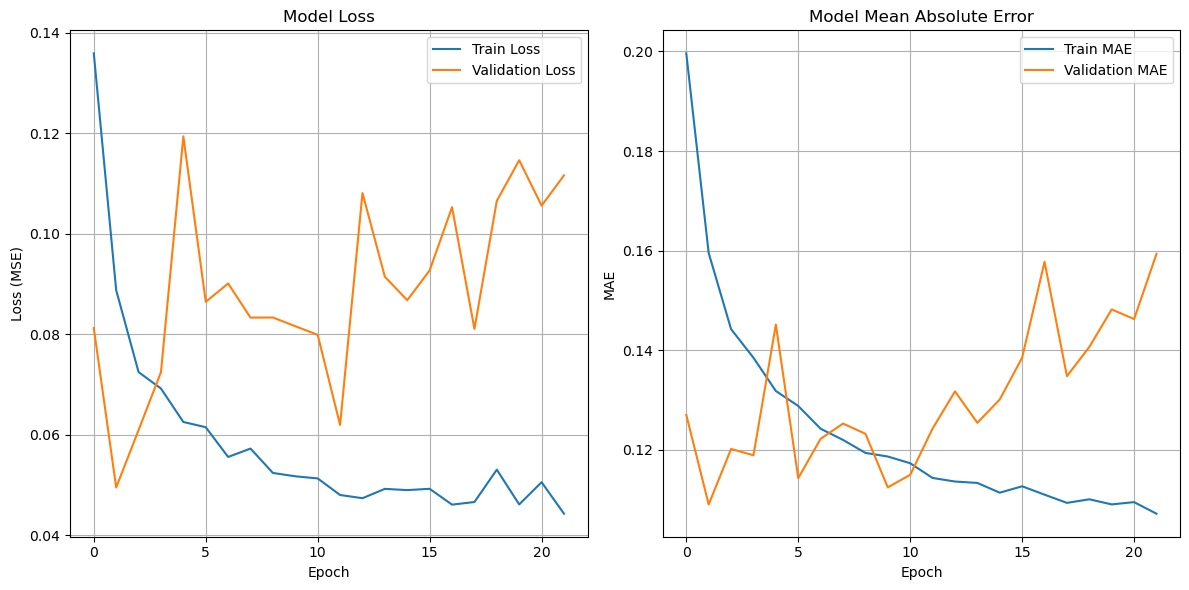

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()